SECTION 1: INITIAL CODE

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import MinMaxScaler
###############################
# this piece of code was provided by a team mate to help automatically extract the queries and observation and remove any duplicates
function = 5
# Read the files
X_init = np.load("initial_inputs.npy")
y_init = np.load("initial_outputs.npy")
queries_file = "queries.txt"
observations_file = "observations.txt"

# Read queries data
import ast
queries_data = []
with open(queries_file, 'r') as f:
    for line in f:
        line = line.replace('array(', 'np.array(')
        queries_data.append(eval(line.strip()))

# Read observations data
observations_data = []
with open(observations_file, 'r') as f:
    for line in f:
        observations_data.append(eval(line.strip()))

# Extract the specified sub-arrays from queries
X = np.array([q[function - 1] for q in queries_data], dtype='float64')
y = np.array([o[function - 1] for o in observations_data])

# Find and remove duplicates
unique_indices = []
seen = set()
for i, x in enumerate(X):
    x_tuple = tuple(x)  # Convert to tuple for hashability
    if x_tuple not in seen:
        seen.add(x_tuple)
        unique_indices.append(i)

# Keep only unique queries and observations
X_unique = np.concatenate((X_init, X[unique_indices]))
y_unique = np.concatenate((y_init, y[unique_indices]))
queries_unique = [queries_data[i] for i in unique_indices]
observations_unique = [observations_data[i] for i in unique_indices]

# Save cleaned data to new files
with open("queries_unique.txt", "w") as f:
    for query in queries_unique:
        f.write(str(query) + "\n")

with open("observations_unique.txt", "w") as f:
    for obs in observations_unique:
        f.write(str(obs) + "\n")

# Save cleaned numpy arrays
np.save("initial_inputs_unique.npy", X_unique)
np.save("initial_outputs_unique.npy", y_unique)

############################
# Create DataFrame
df = pd.DataFrame({
    'param1': X_unique[:, 0],
    'param2': X_unique[:, 1],
    'param3': X_unique[:, 2],
    'param4': X_unique[:, 3],
    'output': y_unique
})

###########################

import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.stats import norm
from scipy.optimize import minimize


# Placeholder for black-box function (replace with experimental evaluation)
def black_box_function(x):
    raise NotImplementedError("Evaluate yield at x = (param1, param2, param3, param4)")

# Expected Improvement acquisition function
def expected_improvement(X, X_sample, y_sample, gp, xi=0.01):
    mu, sigma = gp.predict(X.reshape(-1, 4), return_std=True)
    mu_sample_opt = np.max(y_sample)
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return -ei  # Minimize negative EI

# Bayesian Optimization using data frame
def bayesian_optimization_manual(df, n_iter=10):
    # Extract features and output from data frame
    X = df[['param1', 'param2', 'param3', 'param4']].to_numpy()
    y = df['output'].to_numpy()
    
    # Initialize Gaussian Process
    kernel = Matern(nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X, y)
    
    bounds = np.array([[0, 1], [0, 1], [0, 1], [0, 1]])  # Assume inputs in [0, 1]
    best_x = X[np.argmax(y)]
    best_y = np.max(y)
    
    print(f"Initial best point: {best_x}, Yield: {best_y}")
    
    for i in range(n_iter):
        # Optimize acquisition function
        x0 = np.random.uniform(0, 1, 4)  # Random starting point for optimization
        res = minimize(
            lambda x: expected_improvement(x, X, y, gp),
            x0,
            bounds=bounds,
            method='L-BFGS-B'
        )
        x_next = res.x
        
        # Print point to evaluate
        print(f"Iteration {i+1}: Evaluate at x = {x_next} (param1, param2, param3, param4)")
        
        # Prompt for experimental yield
        y_next = float(input("Enter the yield for this point: "))
        
        # Update data frame
        new_row = pd.DataFrame({
            'param1': [x_next[0]],
            'param2': [x_next[1]],
            'param3': [x_next[2]],
            'param4': [x_next[3]],
            'output': [y_next]
        })
        df = pd.concat([df, new_row], ignore_index=True)
        
        # Update X and y
        X = df[['param1', 'param2', 'param3', 'param4']].to_numpy()
        y = df['output'].to_numpy()
        
        # Refit GP
        gp.fit(X, y)
        
        # Update best
        if y_next > best_y:
            best_x = x_next
            best_y = y_next
            print(f"New best point: {best_x}, Yield: {best_y}")
    
    return best_x, best_y, df

# Example usage (replace 'df' with your actual data frame)
best_x, best_y, updated_df = bayesian_optimization_manual(df, n_iter=10)
print(f"Optimal inputs: {best_x}, Max yield: {best_y}")
# print("Updated data frame:\n", updated_df)


Initial best point: [0.30584223 0.93636618 0.95401692 0.88360492], Yield: 2136.952983936292
Iteration 1: Evaluate at x = [0.83051379 0.7924266  0.44338709 0.87847662] (param1, param2, param3, param4)


Enter the yield for this point:  0.2


Iteration 2: Evaluate at x = [0.53528455 0.45824714 0.94099015 0.79799113] (param1, param2, param3, param4)


Enter the yield for this point:  0


Iteration 3: Evaluate at x = [0.50540583 0.24259782 0.73323127 0.07690087] (param1, param2, param3, param4)


Enter the yield for this point:  4


C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 4: Evaluate at x = [0.30654029 0.90654206 0.58396642 0.70442285] (param1, param2, param3, param4)


KeyboardInterrupt: Interrupted by user

SECTION 2: CODE MODIFICATION

SECTION 3: FINAL RESULT

C:\Users\sabri\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Current best point: [0.30584223 0.93636618 0.95401692 0.88360492], Yield: 2136.952984

--- Local exploration around current best ---
Next point to evaluate: [0.26316434 0.85733273 0.9986843  0.85355839] (param1, param2, param3, param4)
Expected yield at next point: 0.000000
Uncertainty (std): 1.000000

--- Global random exploration ---
Next point to evaluate: [0.87716807 0.13227091 0.08479944 0.79595049] (param1, param2, param3, param4)
Expected yield at next point: 0.000000
Uncertainty (std): 1.000000


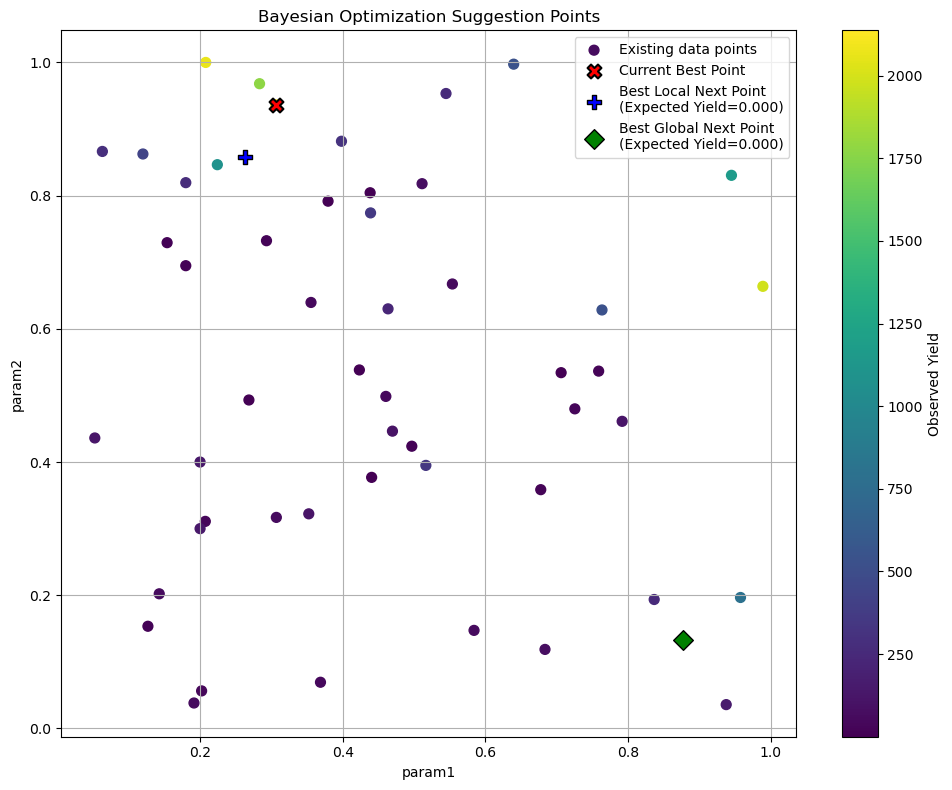

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import MinMaxScaler

##############################

function = 5
# Read the files
X_init = np.load("initial_inputs.npy")
y_init = np.load("initial_outputs.npy")
queries_file = "queries.txt"
observations_file = "observations.txt"

# Read queries data
import ast
queries_data = []
with open(queries_file, 'r') as f:
    for line in f:
        line = line.replace('array(', 'np.array(')
        queries_data.append(eval(line.strip()))

# Read observations data
observations_data = []
with open(observations_file, 'r') as f:
    for line in f:
        observations_data.append(eval(line.strip()))

# Extract the specified sub-arrays from queries
X = np.array([q[function - 1] for q in queries_data], dtype='float64')
y = np.array([o[function - 1] for o in observations_data])

# Find and remove duplicates
unique_indices = []
seen = set()
for i, x in enumerate(X):
    x_tuple = tuple(x)  # Convert to tuple for hashability
    if x_tuple not in seen:
        seen.add(x_tuple)
        unique_indices.append(i)

# Keep only unique queries and observations
X_unique = np.concatenate((X_init, X[unique_indices]))
y_unique = np.concatenate((y_init, y[unique_indices]))
queries_unique = [queries_data[i] for i in unique_indices]
observations_unique = [observations_data[i] for i in unique_indices]

# Save cleaned data to new files
with open("queries_unique.txt", "w") as f:
    for query in queries_unique:
        f.write(str(query) + "\n")

with open("observations_unique.txt", "w") as f:
    for obs in observations_unique:
        f.write(str(obs) + "\n")

# Save cleaned numpy arrays
np.save("initial_inputs_unique.npy", X_unique)
np.save("initial_outputs_unique.npy", y_unique)

###############################

# Create DataFrame
df = pd.DataFrame({
    'param1': X_unique[:, 0],
    'param2': X_unique[:, 1],
    'param3': X_unique[:, 2],
    'param4': X_unique[:, 3],
    'output': y_unique
})

#######################


from sklearn.gaussian_process.kernels import Matern
from scipy.optimize import minimize

# Expected Improvement acquisition function
def expected_improvement(X, X_sample, y_sample, gp, xi=0.01):
    mu, sigma = gp.predict(X.reshape(-1, 4), return_std=True)
    mu_sample_opt = np.max(y_sample)
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return -ei  # Minimize negative EI to maximize expected improvement

# Function to suggest next points with local and global exploration
def suggest_next_point(df, n_restarts=10, perturbation_scale=0.1):
    # Extract features and output from data frame
    X = df[['param1', 'param2', 'param3', 'param4']].to_numpy()
    y = df['output'].to_numpy()

    # Initialize Gaussian Process
    kernel = Matern(nu=2.5)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X, y)

    # Current best
    best_x = X[np.argmax(y)]
    best_y = np.max(y)
    print(f"Current best point: {best_x}, Yield: {best_y:.6f}")

    bounds = np.array([[0, 1], [0, 1], [0, 1], [0, 1]])  # Input domain bounds

    # --- Local exploration: restarts near best_x ---
    best_local_acq_value = np.inf
    best_local_x_next = None

    for i in range(n_restarts):
        random_perturbation = np.random.uniform(-perturbation_scale, perturbation_scale, size=4)
        x0 = best_x + random_perturbation
        x0 = np.clip(x0, bounds[:, 0], bounds[:, 1])
        res = minimize(
            lambda x: expected_improvement(x, X, y, gp, xi=0.01),
            x0,
            bounds=bounds,
            method='L-BFGS-B'
        )
        if res.fun < best_local_acq_value:
            best_local_acq_value = res.fun
            best_local_x_next = res.x

    mu_local, sigma_local = gp.predict(best_local_x_next.reshape(1, -1), return_std=True)

    # --- Global exploration: restarts from uniform random starting points in domain ---
    best_global_acq_value = np.inf
    best_global_x_next = None

    for i in range(n_restarts):
        x0 = np.random.uniform(0, 1, 4)
        res = minimize(
            lambda x: expected_improvement(x, X, y, gp, xi=0.01),
            x0,
            bounds=bounds,
            method='L-BFGS-B'
        )
        if res.fun < best_global_acq_value:
            best_global_acq_value = res.fun
            best_global_x_next = res.x

    mu_global, sigma_global = gp.predict(best_global_x_next.reshape(1, -1), return_std=True)

    # Print results for both methods
    print("\n--- Local exploration around current best ---")
    print(f"Next point to evaluate: {best_local_x_next} (param1, param2, param3, param4)")
    print(f"Expected yield at next point: {mu_local[0]:.6f}")
    print(f"Uncertainty (std): {sigma_local[0]:.6f}")

    print("\n--- Global random exploration ---")
    print(f"Next point to evaluate: {best_global_x_next} (param1, param2, param3, param4)")
    print(f"Expected yield at next point: {mu_global[0]:.6f}")
    print(f"Uncertainty (std): {sigma_global[0]:.6f}")

    plot_results(X, y, best_x, best_local_x_next, best_global_x_next, mu_local[0], mu_global[0])

    return (best_local_x_next, mu_local[0], sigma_local[0]), (best_global_x_next, mu_global[0], sigma_global[0])

def plot_results(X, y, best_x, best_local_x_next, best_global_x_next, mu_local, mu_global):
    # We will plot a 2D projection of the known data and suggestion points
    # For visualization, we use param1 and param2 (first two dims)
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, label='Existing data points')
    plt.colorbar(sc, label='Observed Yield')

    plt.scatter(best_x[0], best_x[1], color='red', s=100, label='Current Best Point', edgecolors='black', linewidth=1.5, marker='X')

    plt.scatter(best_local_x_next[0], best_local_x_next[1], color='blue', s=100,
                label=f'Best Local Next Point\n(Expected Yield={mu_local:.3f})', edgecolors='black', marker='P')

    plt.scatter(best_global_x_next[0], best_global_x_next[1], color='green', s=100,
                label=f'Best Global Next Point\n(Expected Yield={mu_global:.3f})', edgecolors='black', marker='D')

    plt.xlabel('param1')
    plt.ylabel('param2')
    plt.title('Bayesian Optimization Suggestion Points')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


local_result, global_result = suggest_next_point(df, n_restarts=10, perturbation_scale=0.1)



